# Data Assimilation toolbox

In this tutorial, we illustrate the use of the data assimilation toolbox for a simple advective sea ice model.

## Motivation

Nature is complex. Between imperfect numerical simulations and incomplete or inaccurate observations, it is difficult to make informed decisions. Data assimilation methods such as *Bayesian filters* are powerful tools to address these challenges. In a nutshell, filters seek to synthesize improved characterizations of dynamical systems by combining uncertain model predictions with uncertain measurements. This is achieved by propagating an uncertainty estimate - representing our best guess about the system's true state - along with the system's true evolution in quasi-real time, regularly correcting the simulation's predictions with new information. As such, data assimilation methods find regular use in real-time control or forecasting systems, with applications ranging from satellite tracking to weather prediction.

Yet, not all methods are equally suited to the manifold challenges of real dynamics. Beyond the simple settings that permit closed-form solutions, practitioners must often employ ensemble-based strategies instead, which represent uncertainty indirectly through an ensemble of different models, each representing a different possibility of what the true state might be. In this challenge problem, we are advancing new and powerful data assimilation methods with applications not just in sea ice modelling, but beyond.

## The ensemble Kalman filter (EnKF)

One of the most common data assimilation algorithms is the ensemble Kalman filter. In filtering, our main goal is to characterize a conditional distribution of the joint distribution $p(x_t,y_t|y_{1:t-1}^{*})$. At time $t$, this distribution represents our best guess of the current system state $x_{t}$ and our predictions for the next observation $y_{t}$, given all information so far $y_{1:t-1}^{*}$. We then seek to characterize the posterior $p(x_t|y_{1:t}^{*})$, which integrates a new data point $y_{t}$. The EnKF achieves this with the help of a linear, transformative update which transforms samples from a $p(x_t,y_t|y_{1:t-1}^{*})$ (each representing a potential truth, and a predicted observation) into posterior samples. The EnKF's equations are given by 

\begin{equation}
x_{t}^{*} = x_{t} - \Sigma_{x_{t},y_{t}}\Sigma_{y_{t},y_{t}}^{-1}(y_{t} - y_{t}^{*}) \tag{1}
\end{equation}

where $\Sigma_{x_{t},y_{t}}$ is the covariance matrix between $x_{t}$ and $y_{t}$, and $\Sigma_{y_{t},y_{t}}^{-1}$ is the inverse auto-covariance of $y_{t}$.

<img align="left" src="figures/EnKF.gif" width="50%"> **Figure 1:** The EnKF's update is optimal if the joint distribution is multivariate Gaussian.  The posterior samples perfectly extract a vertical slice of the joint distribution.

<img align="left" src="figures/spiral_linear.gif" width="50%"> **Figure 2:** If the joint distribution is non-Gaussian, as in the example of this spiral,  the EnKF's update does not extract the correct solution. In this instant, the filtering update - supposed to adjust the state estimates on the right marginal - does basically nothing. This is because the EnKF update cannot retrieve the correct solution, as it is only linear.

## The ensemble transport filter (EnTF)

The ensemble transport filter (EnTF) is a nonlinear generalization of the EnKF, which increases its accuracy in nonlinear or non-Gaussian systems. Due to the inherent flexibility of the framework, there is no single straightforward equation to reproduce here. Instead, we refer the interested reader to the original manuscript by [Spantini et al. (2022)](https://epubs.siam.org/doi/abs/10.1137/20M1312204) or the extensions to nonlinear smoothing by Ramgraber et al. (2023), [here](https://arxiv.org/abs/2210.17000) and [here](https://arxiv.org/abs/2210.17435). In brief, these filters are based on triangular transport maps. Such transport maps seek a monotone, invertible, triangular function $\mathbf{S}$ that converts samples from a joint target probability density function (such as the joint density $\pi$ of $y_t$ and $x_t$) into samples from a standard Gaussian reference distribution of equal dimension. 

Due to the triangular structure of the map, it can be conditionally inverted to sample any conditionals of the original target distribution $\pi(y_t,x_t)$, such as the posterior $\pi(x_t |y_t^*)$ - the output of a filtering operation. The flexibility of the framework arises from the freedom in defining the parameterization of the map S. If this map comprises of linear functions, it can be demonstrated that the EnKF emerges as a linear special case (Figure 2). Choosing more complex nonlinear functions instead generalizes this algorithm (Figure 3). 

<img align="left" src="figures/spiral_nonlinear.gif" width="50%"> **Figure 3:** A nonlinear EnTF can realize a nonlinear data assimilation update, which can extract the correct state posterior.

One of our latest innovations is an efficient map adaptation algorithm (manuscript in preparation) that automatically identifies a parsimonious map parameterization, complex enough to capture non-Gaussian features of $\pi$, yet simple enough to avoid unfavourable bias-variance trade-offs. The core idea of the new proposed method is to quantify the discrepancy between the pushforward samples (the output) of a sub-optimal map to the desired standard-Gaussian reference distribution. We then use this information to inform places in which the map must be adjusted to obtain a superior result.

# Data assimilation example

To demonstrate the performance of these methods for sea ice dynamics, we have prepared a data assimilation toolbox which implements both the EnKF and an early version of the adaptive EnTF. To begin, let us load a number of basic libraries.

In [1]:
import numpy as np # For numerics
import matplotlib.pyplot as plt # For plotting
import scipy.stats # For statistics
import copy # For copying

In addition to these basic libraries, we also require three files:

 - `forecast_model`: As the name implies, this file contains a `forecast` function which propagates a state estimate $x_{t-1}$ to time $t$, yielding a predicted state $x_{t}$.
 - `observation_model`: Likewise, this file contains the `linear_observation_model`, which uses the predicted state $x_{t}$ to predict the corresponding observation $y_{t}$.
 - `ensemble_filters`: This file contains an object which implements both the EnKF and the adaptive EnTF. We can select the desired algorithm later.

In [2]:
from forecast_model import forecast
from observation_model import linear_observation_model
from ensemble_filters import ensemble_filters

In this tutorial, we will consider a simple, one-dimensional, advective sea ice model with priodic boundary conditions (i.e., ice which leaves the model domain to the right re-enters it to the left, and vice versa). This periodic domain places special requirements on spatially correlated noise and other continuous quantities to ensure these quantities remain continuous over the periodic boundary condition. One way to achieve this is with the help of a circular convolution function.

In [3]:
# Out sea ice domain is circular. To sample circular noise efficiently, we need
# a circular convolution. This is what this function is for.
def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

Now let us initiate the model:

In [4]:
# Get a colormap for later plotting
cmap    = plt.get_cmap("turbo")

# Set a random seed
np.random.seed(0)

# Let's set some parameters
dx          = 1E4   # Cell size in m
dt          = 360   # Time step length in s
T           = 365   # Number of time steps (for longer simulations, increase this number)
N           = 1000  # Ensemble size
D           = 200   # State dimension (how many cells?)
obs_sd      = 0.1   # Observation error standard deviaton
forecast_sd = 0.5   # Forecast error standard deviation

The `linear_observation_model` requires an observation operator `H`, which extracts the base values for the observations $y_{t}$ from the state vector $x_{t}$. Here, we initiate this observation operator. It ends up being a matrix of dimension $D \times O$, where $D$ is the state dimension and $O$ is the observation dimension.

As sea ice observations are often based on remote sensing, they are often spatially integrated. One way to emulate this effect for a linear observation operator `H` is with the help of a Gaussian kernel.

In [5]:
# Create an observation operation
obs_range   = 10 # Make an observation every 10 cells
obspts      = np.arange(0,D,obs_range)+int(obs_range/2) # Arrange it around the domain
H           = np.zeros((len(obspts),D)) # Create an empty observation operator
for row in range(len(obspts)): # Every observation is spatially aggregated
    H[row,:]= np.exp(-(np.arange(D)-obspts[row])**2/(obs_range*5))
H[H < 0.01] = 0 # Truncate low contributions
H           = np.einsum('ij,i->ij',H,1/np.sum(H,axis=-1)) # Normalize the rows

# How many observations do we make?
O       = H.shape[0]

### Generate the wind forcing

The sea ice model we consider is driven advectively by a velocity field. To emulate this effect, we must create artificial wind forcing. We can achieve this by creating a 2D noise field of size $D \times T$, where $D$ is the state dimension and $T$ is the number of time steps, and convolving it with a 2D circular convolution to ensure smoothness in both time and space. We then normalize this wind, and scale it to the range between -10 m/s and +10 m/s.

Text(0, 0.5, 'space in cells')

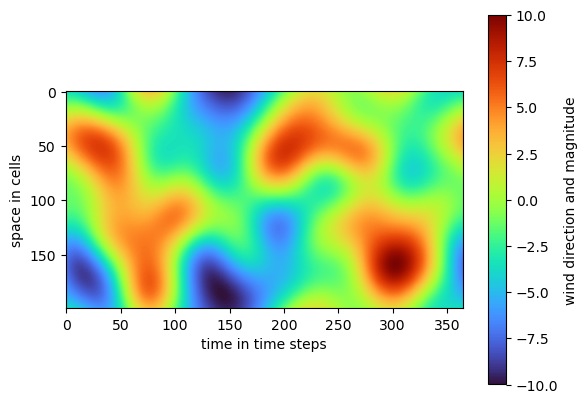

In [6]:
# The wind focing is circular and random
filter_scale = 100 # Size of the convolution filter
correlation_scale = 500 # Spatial correlation of wind noise

# Generate the convolution filter kernel
x = np.arange(-filter_scale, filter_scale)
y = np.arange(-filter_scale, filter_scale)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X*X + Y*Y)
filter_kernel = np.exp(-dist**2/(2*correlation_scale))

# Sample raw noise as a basis for the wind
wind = np.random.randn(D,T) 

# Apply the 2D convolution
#   first dimension: space
#   second dimension: time
wind = scipy.signal.convolve2d(wind, filter_kernel, mode='same', boundary='wrap')

# Normalize the wind between -10 and 10 m/s
wind    -= np.min(wind)
wind    /= np.max(wind)
wind    = wind*2-1
wind    *= 10

# Plot the wind forcing
plt.imshow(wind, vmin = -10, vmax = 10, cmap = cmap)
plt.colorbar(label="wind direction and magnitude")
plt.xlabel("time in time steps")
plt.ylabel("space in cells")

### Create the initial conditions

To begin, let us define the synthetic initial condition for both the reference solution and the prior.

(2.5, -0.5)

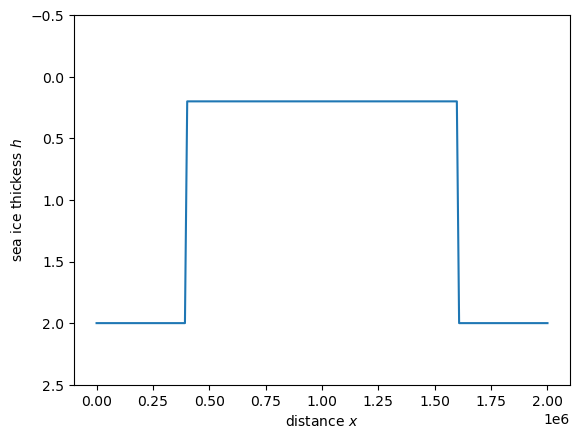

In [7]:
# Create the initial state vector
h       = np.zeros((D)) + 0.2
h[:40]  = 2
h[-40:] = 2

# Plot the initial condition
plt.plot(
    np.linspace(0,D*dx,D),
    h)
plt.xlabel("distance $x$")
plt.ylabel("sea ice thickess $h$")
plt.gca().invert_yaxis()
plt.gca().set_ylim([2.5,-0.5])

### Generate the synthetic reference and the observations

Since this is a synthetic test case, we must simulate the "true" dynamics of the system the data assimilation algorithm will seek to reproduce.

In [8]:
# Let's simulate the true sea ice dynamics
hs_true     = [h]
for t in np.arange(1,T,1):
    new_h   = forecast(
        u   = wind[:,t],
        h   = hs_true[-1],
        dx  = dx,
        dt  = dt)
    hs_true.append(new_h)
hs_true     = np.asarray(hs_true).T

In lieu of real observations, we also generate the synthetic observations based off the synthetic true state. In the current version, the `linear_observation_model` supports two types of observation errors: For `"additive"` errors, homoscedastic Gaussian noise is added to the true state:

$$y_{t} = Hx_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,\sigma_{obs}^2)$$

As an alternative, you can select `"multiplicative"` errors. In this case, the error is heteroscedastic, and its magnitude scales with the true state. In consequence, the observation predictions are generated as:

$$y_{t} = Hx_{t}\epsilon_t, \quad \epsilon_t \sim \mathcal{N}(1,\sigma_{obs}^2)$$

In [9]:
# Generate synthetic observations
Y       = []
for t in range(T):
    Y   .append(
        linear_observation_model(
            x       = hs_true[:,t][np.newaxis,:],
            H       = H,
            obs_sd  = obs_sd,
            noise   = "additive"))
Y       = np.asarray(Y).T

### Initiate the filtering algorithm

Before we start filtering, we need to initiate the ensemble and create arrays to store the filtering results. To ensure that our initial state estimates $x_{t=0}$ are continuous over the periodic boundary conditions, we generate the initial samples using circular convolution, then rescale the output between 0.25 and 3.25m.

In [10]:
# Pre-allocate a variable for the states
hs  = np.zeros((N,D,T))

# Draw the initial states 
noise       = np.random.randn(N, D)
kernel      = np.asarray([np.exp(-x**2/2) for x in np.linspace(-10,10,D)])
for n in range(N):
    noise[n,:]  = conv_circ(noise[n,:], kernel )
    noise[n,:]  -= np.min(noise[n,:])
    noise[n,:]  /= np.max(noise[n,:])
    noise[n,:]  *= 3
    noise[n,:]  += 0.25
hs[:,:,0]   = copy.copy(noise)

# Initiate an array for simulated observations
Y_sim       = np.zeros((N,O,T))

## Now start filtering

Our last code block is large, as it involves a for loop. We begin by setting a flag defining whether or not we want to plot the DA algorithm's progress. We then initiate a `filters` object which includes both the EnKF and the adaptive EnTF, and specify which method we want to use with another flag.

We then enter the data assimilation loop, which goes through all time steps. This loop comprises of several steps. First, we use the `linear_observation_model` to generate predicted observations based on the latest state forecasts `hs`. With both `hs` and `Y_sim`, we then proceed to the filtering update, where we also provide the synthetic observations `Y`. As the data assimilation update can sometimes generate physically impossible values, such as negative thicknesses, we truncate negative ice thicknesses at zero.

This concludes the data assimilation update, which is then followed with a forecast step during which we propagate the updated state estimate `hs` to the next timestep. As we also consider the forecast uncertain, we add smooth, stochastic forecast noise, which we once more obtain through 1D circular convolution, scaled to the range of $[-\sigma_{forecast},+\sigma_{forecast}]$.

Finally, there is a complex block which plots the current state of the system if the appropriate flag has been set.

Filtering 0


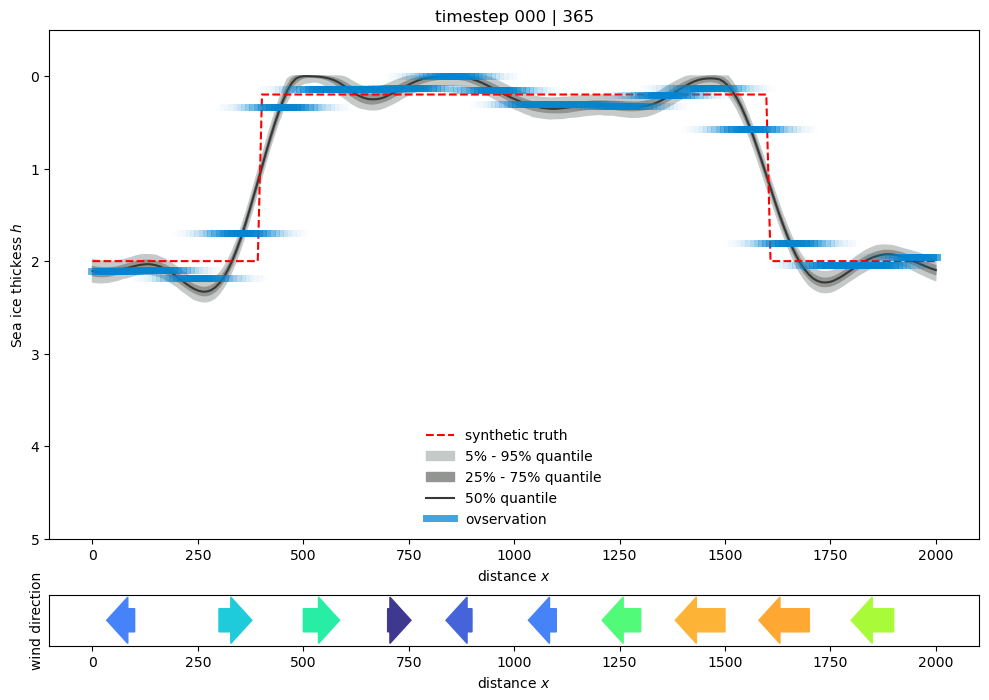

Filtering 1


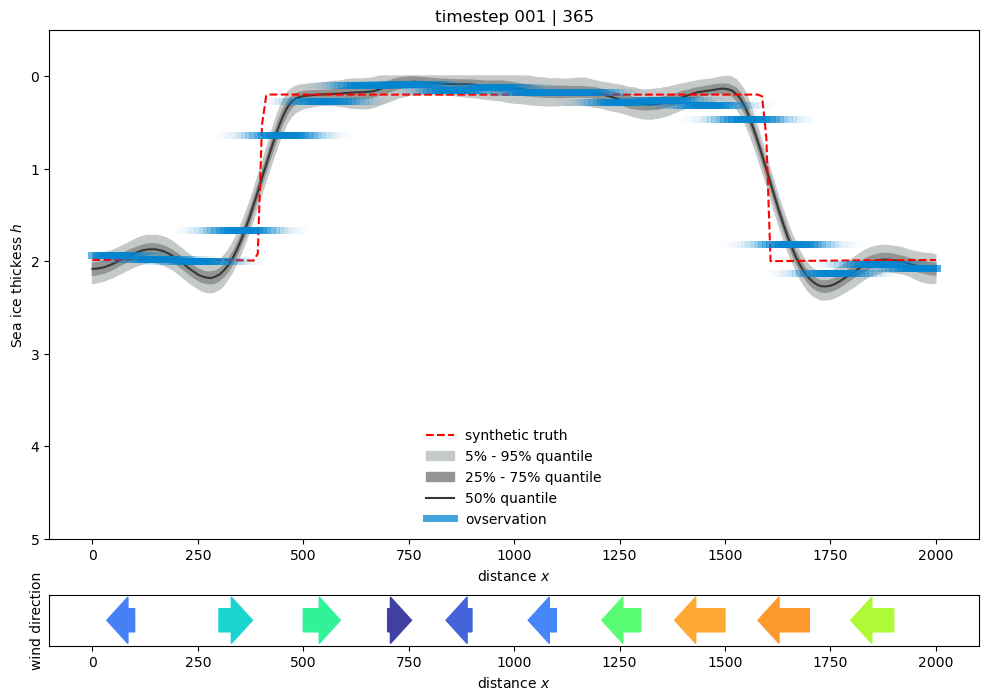

Filtering 2


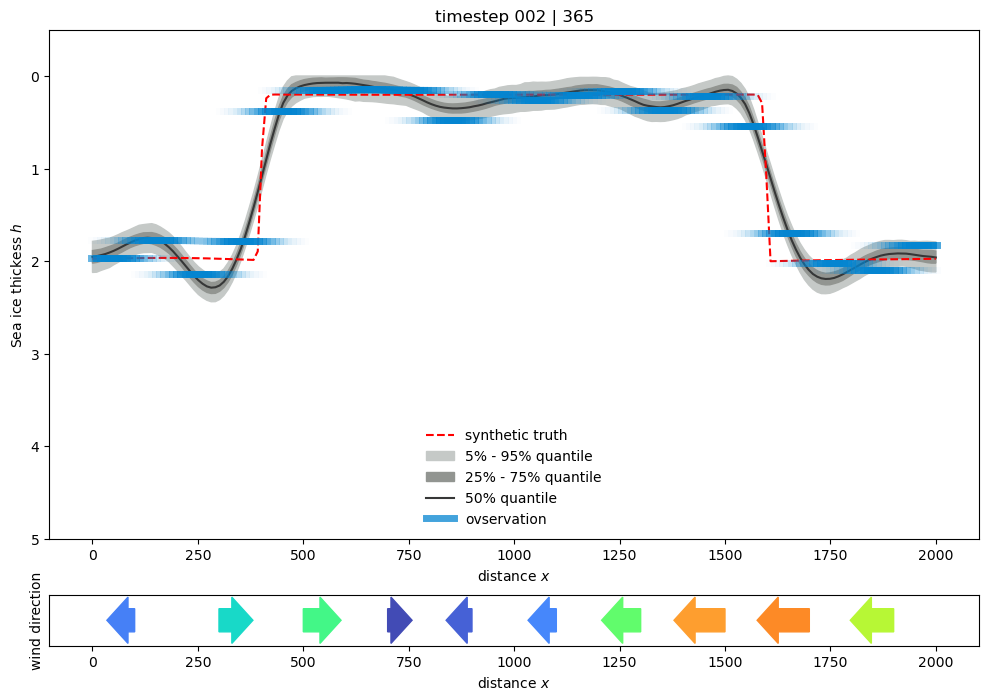

Filtering 3


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [13]:
# Shall we plot the output?
plot_results= True

# Initiate an ensemble filter object
filters     = ensemble_filters()

filter_mode = "EnKF" # alternative: "EnTF"

# Let's start filtering
for t in np.arange(0,T,1):
    
    print("Filtering "+str(t))
    
    # Step 1: implement the EnKF update ---------------------------------------
    
    # Generate observations
    Y_sim[:,:,t]    = linear_observation_model(
        x       = hs[:,:,t],
        H       = H,
        obs_sd  = obs_sd,
        noise   = "additive")
    
    # apply the filter update
    if filter_mode == "EnKF": # Apply an EnKF update
        hs[:,:,t]   = filters.EnKF(
            x       = hs[:,:,t],
            y       = Y_sim[:,:,t],
            y_obs   = Y[:,:,t])
    else: # Apply a nonlinear adaptive EnTF update
        hs[:,:,t]   = filters.EnTF(
            x       = hs[:,:,t],
            y       = Y_sim[:,:,t],
            y_obs   = Y[:,:,t])
    
    # Prevent physically impossible states
    hs[:,:,t][hs[:,:,t] < 0] = 0
    
    # Step 2: Forecast to the next timestep -----------------------------------
    
    if t < T-1:
        
        # Sample circular noise
        noise       = np.random.randn(N, D)
        kernel      = np.asarray([np.exp(-x**2/2) for x in np.linspace(-10,10,D)])
        for n in range(N):
            noise[n,:]  = conv_circ( noise[n,:], kernel )
            noise[n,:]  -= np.min(noise[n,:])
            noise[n,:]  /= np.max(noise[n,:])
            noise[n,:]  = noise[n,:]*2 - 1
            noise[n,:]  *= forecast_sd
    
        # Make a forecast
        hs[:,:,t+1] = forecast(
            u       = np.repeat(wind[:,t][np.newaxis,:],axis=0,repeats=N).flatten(),
            h       = hs[:,:,t].flatten(),
            dx      = dx,
            dt      = dt,
            noise   = noise.flatten()).reshape((N,D))
    
    # Step 3: Plot results
    if plot_results:
    
        # Extract quantiles
        q05     = np.quantile(hs[:,:,t], q = 0.05, axis = 0)
        q25     = np.quantile(hs[:,:,t], q = 0.25, axis = 0)
        q50     = np.quantile(hs[:,:,t], q = 0.50, axis = 0)
        q75     = np.quantile(hs[:,:,t], q = 0.75, axis = 0)
        q95     = np.quantile(hs[:,:,t], q = 0.95, axis = 0)
    
        # Plot results
        plt.close("all")
        plt.figure(figsize=(12,8))
        
        from matplotlib.gridspec import GridSpec
        gs  = GridSpec(
            nrows   = 2,
            ncols   = 1,
            height_ratios = [1,0.1])
        
        plt.subplot(gs[0])
        
        plt.title("timestep "+str(t).zfill(3)+" | "+str(T).zfill(3))
        
        plt.plot(
            np.linspace(0,2000,D),
            hs_true[:,t],
            color   = "r",
            ls      = "--",
            label   = "synthetic truth",
            zorder  = 5)
        
        xpts    = np.linspace(0,2000,D)
        dxpts   = np.diff(xpts[:2])
        for o in range(O):
            
            for idx,xpt in enumerate(xpts):
            
                if H[o,idx] != 0:
                    plt.plot(
                        [xpt - dxpts/4,xpt + dxpts/4],
                        [Y[o,0,t],Y[o,0,t]],
                        alpha   = H[o,idx]/np.max(H[o,:]),
                        color   = "xkcd:cerulean",
                        zorder  = 10,
                        lw      = 5)
            
        plt.fill(
            list(np.linspace(0,2000,D))+list(np.flip(np.linspace(0,2000,D))),
            list(q05) + list(np.flip(q95)),
            color   = "xkcd:silver",
            label   = "5% - 95% quantile",
            zorder  = 1)
        
        plt.fill(
            list(np.linspace(0,2000,D))+list(np.flip(np.linspace(0,2000,D))),
            list(q25) + list(np.flip(q75)),
            color   = "xkcd:grey",
            label   = "25% - 75% quantile",
            zorder  = 2)
        
        plt.plot(
            np.linspace(0,2000,D),
            q50,
            color   = "xkcd:dark grey",
            label   = "50% quantile",
            zorder  = 3)
        
        plt.xlabel("distance $x$")
        plt.ylabel("Sea ice thickess $h$")
        
        plt.gca().invert_yaxis()
        plt.gca().set_ylim([5,-0.5])
        
        # Draw an observation line for the legend only
        plt.plot(
            [50,51],
            [-100,-100],
            alpha   = 0.75,
            color   = "xkcd:cerulean",
            label   = "ovservation",
            lw      = 5)
        
        plt.legend(loc="lower center", frameon = False)
        
        xlims = plt.gca().get_xlim()

        plt.subplot(gs[1])
        
        plt.gca().set_xlim(xlims)
        
        arrowpts = (np.arange(0,2000,200)+100)
        
        for pt in arrowpts:
            
            idx = int(pt*D/2000)
        
            height  = 0.4
            
            xpos    = pt
            ypos    = 0
            
            arrowwidth = 0.025*2000
            hscale  = 1
            
            arrow   =  np.column_stack((
                np.asarray([
                    xpos, 
                    xpos + wind[idx,t]/10*100*hscale]+\
                 list(xpos + wind[idx,t]/10*100*hscale + np.sign(wind[idx,t])*np.asarray([0., arrowwidth, 0.]))+\
                [xpos + wind[idx,t]/10*100*hscale, xpos]),
                np.asarray([ypos + height, ypos + height]+list(ypos + np.asarray([1., 0., -1.])*height*2)+[ypos - height, ypos - height]) ))
            
            plt.fill(
                arrow[:,0],
                arrow[:,1],
                color   = cmap(np.abs(wind[idx,t]/10)))
    
        # Remove all axis ticks
        plt.tick_params(left=False,
                        labelleft=False)
        plt.ylabel("wind direction")
        plt.xlabel("distance $x$")
    
        plt.show()
    
        plt.savefig("DA_step_"+str(t).zfill(3)+".png",dpi=300)

As the data assimilation run can take a long time due to the computational demand of the sea ice model, we have prepared an animation of the expected output. Experiment with different parameters and setups, and explore the `forecast_model`, `observation_model`, and `ensemble_filters` Python files.

<img align="left" src="figures/animation_new.gif" width="100%"> 

**Figure 4:** An animation of the output of the previous data assimilation loop.